In [1]:
# https://github.com/marshackVB/ml-recipes/blob/master/PandasUDF_Hyperopt_Spark.ipynb
# https://www.phdata.io/blog/bayesian-hyperparameter-optimization-with-mlflow/

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from datetime import date,datetime,timedelta

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import StringType, DoubleType, StructType, StructField, DateType, FloatType
from pyspark.sql.functions import *

# initialise sparkContext
spark = SparkSession.builder \
    .master('local') \
    .appName('myAppName') \
    .config('spark.executor.memory', '10gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
sqlContext = SQLContext(sc)

import os
from functions.func import *

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [182]:
from sklearn.utils.validation import check_consistent_length
def symm_mean_absolute_percentage_error(y_true, y_pred, sample_weight=None):
    epsilon = np.finfo(np.float64).eps
    smape = 2*np.abs(y_pred - y_true) / np.maximum(np.abs(y_true)+np.abs(y_pred), epsilon)
    check_consistent_length(y_true, y_pred, sample_weight)
    output_errors = np.average(smape, weights=sample_weight, axis=0)
    return output_errors


# modified from https://blog.datadive.net/prediction-intervals-for-random-forests/
def pred_ints(model, X, interval_width):
    percentile = interval_width * 100
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X[x].reshape(1,-1))[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return np.asarray(err_down), np.asarray(err_up)


def config_objective(df, feature_cols, label_col, model, scoring, cv):
  
    """Configure the Hyperopt objective function

    Arguments:
    df: Pandas DataFrame:     The Pandas Dataframe on which to fit the model
    features_cols: List[str]: List of column names that represent the model features
    label_col: str            The label column name
    model: regressor          The model object that will be fit on the data, for instance a random forest
    scoring: str, scorer func Scoring method to use for selecting the best model
    cv: int, cv generator     The number of cross validation folds or cv generator
    """

    def objective(params):

        """The Hyperopt objective function"""

        model_conf = model(**params)

        scores = cross_val_score(model_conf, df[feature_cols], df[label_col], scoring=scoring, cv=cv)
        loss = -scores.mean()     # neg score as loss

        return {'loss': loss, 'params': params, 'status': STATUS_OK}  

    return objective

def fit_models_config(feature_cols, label_col, model, search_space,  
                      experiment_name=None, scoring='smape', 
                      cv=3, max_evals=100, 
                      bjective=config_objective, 
                      fit_best=True, 
                      ts=True):
  
    """Apply a scikit learn model to a group of data within a Spark DataFrame using a Pandas UDF

    Arguments:
    features_cols: List[str]:       List of column names that represent the model features
    label_col: str:                 Column to be predicted
    model: regressor :              (Regressor)Model to fit to the data
    search_space: Dict:             Grid search data structure containing the parameters to search
    experiment_location: str:       Name of MLFlow experiment.If None, create a notebook experiment  
    scoring: str:                   Scoring method to use for validation
    cv: int:                        The number of cross validation folds 
    max_evals: int:                 Max Hyperopt evaluations to run
    objective: function:            The Hyperopt objective function
    fit_best: boolean:              If True, a model with the best parameters will be fit and logged in MLFlow
    ts: boolean:                    If True, the cross validation is a timeseries cross validation     
    """
    SEED = 123
    
    if ts:
        cv = TimeSeriesSplit(n_splits=cv,test_size=days_to_forecast)
    if scoring == 'smape':
        scoring = make_scorer(symm_mean_absolute_percentage_error, greater_is_better=False)   # neg_smape as scoring    
        
    def fit_models(keys, data: pd.DataFrame) -> pd.DataFrame:
        """Fit the model; log the best model and its paramenters to 
        MLFlow"""

        # identify time series to forecast
        Key1_id = keys[0]
        Key2_id = keys[1]
        group_name = '{}_{}'.format(Key1_id,Key2_id)
        train_data = data
        train_data.sort_values(by='ds',inplace=True) #train_data.reset_index(drop=True, inplace=True)
            
        if experiment_name is not None:
            mlflow.set_experiment(experiment_name)
            # Enable getting Experiment Details later by experiment = mlflow.get_experiment_by_name(experiment_name) 

        with mlflow.start_run() as run:

            # Configure and apply Hyperopt
            bayes_trials = Trials()
            objective_config = config_objective(train_data, feature_cols, 
                                                label_col, model, scoring=scoring, cv=cv)

            best_params = fmin(
                fn=objective_config, 
                space=search_space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=bayes_trials, 
                rstate=np.random.default_rng(SEED))

            best_model_score = np.round(bayes_trials.best_trial['result']['loss'], 4)

            # Create model results output dataset
            model_results_df = pd.DataFrame([(group_name, best_model_score)], 
                                            columns= ['node', 'best_model_score'])

            # Log best model parameters and statistics to MLFlow
            mlflow.set_tag("ts_key", group_name)

            mlflow.set_tag("model_type", model.__name__)

            mlflow.log_metric("smape", best_model_score)

            mlflow.log_params(best_params)

            # Fit the best model on the full training dataset for the group
            if fit_best:

                # Configure and fit best model
                #best_params_as_int = {param_name: int(value) for param_name, value in best_params.items()}
                best_params['n_estimators'] = int(best_params['n_estimators'])
                # best_params['min_samples_split'] = int(best_params['min_samples_split'])
                # best_params['max_depth'] = int(best_params['max_depth'])
                # best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
                best_model_conf = model(**best_params)
                best_model_conf.fit(train_data[feature_cols], train_data[label_col])

                # Log the best model to MLFlow
                mlflow.sklearn.log_model(sk_model=best_model_conf, 
                                          artifact_path='tuned_model')

        return model_results_df

    return fit_models


def apply_models_config(features_cols, score="smape", experiment_id=None):
  
    """For each distinct group (values in groupBy statement), load the group's best model and 
    perform a prediction

    Arguments:
    features_cols: List[str]:       List of column names that represent the model features
    scoring: str                    Scoring method to use for selecting the best model
    experiment_id: str              The id of the experiment from which to select models. Note, if
                                  using the notebook experience (no external MLFlow experiment created)
                                  then the experiment id should equal to the notebook id(see top lines)

    """

    def apply_models(keys, data: pd.DataFrame) -> pd.DataFrame:

        """Load the relvent model for the selected group and generate a
        prediciton for the group"""

        # identify ts_key to forecast
        Key1_id = keys[0]
        Key2_id = keys[1]
        group_name = '{}_{}'.format(Key1_id,Key2_id)

        # Find the best model for this group with lowest scoring metric (smape)
        query = "tags.model_type = 'RandomForestRegressor' and attributes.status = 'FINISHED' and metrics.smape <= 2 and tags.ts_key ='{}'".format(group_name)
        best_run_df = mlflow.search_runs(experiment_id, filter_string=query,order_by=["metrics.smape"],max_results=1)

        best_model_run_id = best_run_df.run_id.values[0]

        # Load the best model via its run_id
        model_loc = os.path.join(os.getcwd(), f"mlruns/{experiment_id}/{best_model_run_id}/artifacts/tuned_model")
        loaded_model = mlflow.sklearn.load_model(model_loc)
        
        # make sure the data are in correct order while using pyspark
        data.sort_values(by='ds',inplace=True)
        # Perform forecast; combine features and predictions
        yhat = np.round(loaded_model.predict(data[features_cols]))
        yhat_lower, yhat_upper = pred_ints(loaded_model, data[features_cols].values, interval_width=0.95)
        preds_np = np.concatenate(
        (
          yhat.reshape(-1,1), 
          yhat_lower.reshape(-1,1), 
          yhat_upper.reshape(-1,1)
          ), axis=1
        )
        forecast_pd = pd.DataFrame(preds_np, columns=['yhat', 'yhat_lower', 'yhat_upper'])
        for col in ['yhat', 'yhat_lower', 'yhat_upper']:
            forecast_pd[col] = forecast_pd[col].clip(lower=0.0)
       
        # PREPARE RESULTS
        # ---------------------------------
        # merge forecast with history
        results_pd = pd.concat(
        [data['ds'], data['y'], forecast_pd],
        axis=1
        )

        # get ts_key from incoming data set
        results_pd['Key1'] = Key1_id
        results_pd['Key2'] = Key2_id
        results_pd['run_id'] = best_model_run_id

        return results_pd

    return apply_models

# modified from https://github.com/facebook/prophet/blob/master/python/fbprophet/plot.py

from matplotlib import pyplot as plt
from matplotlib.dates import (
        MonthLocator,
        num2date,
        AutoDateLocator,
        AutoDateFormatter,
    )
from matplotlib.ticker import FuncFormatter

def generate_plot( model, forecast_pd, xlabel='ds', ylabel='y'):
    ax=None
    figsize=(10, 6)

    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()

    history_pd = forecast_pd[forecast_pd['y'] != np.NaN]
    fcst_t = forecast_pd['ds'].dt.to_pydatetime()

    ax.plot(history_pd['ds'].dt.to_pydatetime(), history_pd['y'], 'k.')
    ax.plot(fcst_t, forecast_pd['yhat'], linestyle='-', c='#0072B2', label='forecast')
    ax.fill_between(fcst_t, forecast_pd['yhat_lower'], forecast_pd['yhat_upper'], color='#0072B2', alpha=0.2)

    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()

    return fig

def load_model(key1_id, key2_id, experiment_id):
    """
    Load model from mlruns
    """
    group_name = '{}_{}'.format(key1_id, key2_id)
    
    # Find the best model for this group with lowest scoring metric (smape)
    query = "tags.model_type = 'RandomForestRegressor' and attributes.status = 'FINISHED' and metrics.smape <= 2 and tags.ts_key ='{}'".format(group_name)
    best_run_df = mlflow.search_runs(experiment_id, filter_string=query,order_by=["metrics.smape"],max_results=1)

    best_model_run_id = best_run_df.run_id.values[0]

    # Load the best model via its run_id
    model_loc = os.path.join(os.getcwd(), f"mlruns/{experiment_id}/{best_model_run_id}/artifacts/tuned_model")
    model_cv_smape = best_run_df["metrics.smape"].values[0]
    model = mlflow.sklearn.load_model(model_loc)
    
    return model, best_run_df, model_cv_smape

def plot_forecast(forecast_pd, model_cv_smape ):
    """
    Forecast Plot with intervals. 
    """

    # construct a visualization of the forecast
    forecast_pd.sort_values(by='ds',inplace=True)
    forecast_pd['ds'] = pd.to_datetime(forecast_pd['ds'], errors='coerce')

    train = forecast_pd[forecast_pd['ds'].dt.date <= last_train_date]
    test = forecast_pd[forecast_pd['ds'].dt.date > last_train_date]
    test_smape = np.round(symm_mean_absolute_percentage_error(test['y'], test['yhat']),4)

    predict_fig = generate_plot(loaded_model, forecast_pd, xlabel='date', ylabel='inflow')
    plt.plot(test['ds'], test['y'], label='actual', c='#249156')
    plt.title('Validation data v. forecast of {} with smape(avg on fh) cv:{:.4f} vs. test:{:.4f}'.format(group_name, model_cv_smape, test_smape))
    plt.legend();

    # adjust the x-axis to focus on a limited date range
    xlim = predict_fig.axes[0].get_xlim()
    new_xlim = (datetime.strptime('2020-9-15','%Y-%m-%d'), datetime.strptime('2022-03-17','%Y-%m-%d'))
    predict_fig.axes[0].set_xlim(new_xlim)
    # display the chart
    plt.show()

# 1. Paramaters

In [2]:
experiment_name = "forecast_pyspark"
days_to_forecast = 14
last_train_date = date(2021, 12, 31)
use_sample_data = True

# 2. Data Input

In [4]:
df_input = sqlContext.read.parquet("sample_data/sample_data.parquet")

In [5]:
if not use_sample_data:
    # to read parquet file
    df_input = sqlContext.read.parquet('data/forecast_encoded_data.parquet')
    df_input = df_input.filter( ( col('Key1') == 'N01') & (col('Key2').isin(['76', '62']) ) )

    unique_ts = df_input_train.select(['Key1', 'Key2']).drop_duplicates().toPandas()
    
label_col = 'y'
feature_cols = [column for column in df_input.columns if column not in [label_col, 'ds', 'Forecast', 'Key1','Key2']]

df_input_train = df_input.filter(col('ds') <= last_train_date )
df_input_test = df_input.filter(col('ds') > last_train_date )

In [6]:
check_key1 = 'N01'
check_key2 = '76'
df_input_train.filter( (col('Key1') == check_key1) &  (col('Key2') == check_key2) & (col('ds') > '2021-11-01')  ).sort(col('ds')).show()

+----+----+-------------------+----+-----+---------+---+
|Key1|Key2|                 ds|year|month|dayofweek|  y|
+----+----+-------------------+----+-----+---------+---+
| N01|  76|2021-11-02 00:00:00|2021|   11|        3|100|
| N01|  76|2021-11-03 00:00:00|2021|   11|        4|189|
| N01|  76|2021-11-04 00:00:00|2021|   11|        5|313|
| N01|  76|2021-11-05 00:00:00|2021|   11|        6|311|
| N01|  76|2021-11-06 00:00:00|2021|   11|        7| 59|
| N01|  76|2021-11-07 00:00:00|2021|   11|        1|  0|
| N01|  76|2021-11-08 00:00:00|2021|   11|        2|221|
| N01|  76|2021-11-09 00:00:00|2021|   11|        3|228|
| N01|  76|2021-11-10 00:00:00|2021|   11|        4| 72|
| N01|  76|2021-11-11 00:00:00|2021|   11|        5|335|
| N01|  76|2021-11-12 00:00:00|2021|   11|        6|302|
| N01|  76|2021-11-13 00:00:00|2021|   11|        7| 70|
| N01|  76|2021-11-14 00:00:00|2021|   11|        1|  0|
| N01|  76|2021-11-15 00:00:00|2021|   11|        2|166|
| N01|  76|2021-11-16 00:00:00|

# 3. Model Training

In [7]:
# Hyperopt search space
search_space = {
  'n_estimators':scope.int(hp.uniform('n_estimators',100,500)),
  #'max_depth':scope.int(hp.uniform('max_depth',5,20)),
  #'min_samples_leaf':scope.int(hp.uniform('min_samples_leaf',1,5)),
  #'min_samples_split':scope.int(hp.uniform('min_samples_split',2,6)), #num_features_for_split = sqrt(total_input_features)
  #'max_samples': hp.uniform("max_samples",0.5, 1)
}


# Pandas_UDF requires a Spark Schema that matches the output of the UDF
fit_schema = StructType([StructField('node', StringType(), True),
                         StructField('best_model_score', DoubleType(), True)])


fit_models = fit_models_config(feature_cols = feature_cols, 
                               label_col = label_col,
                               model = RandomForestRegressor,
                               search_space = search_space,
                               days_to_forecast = days_to_forecast,
                               experiment_name = experiment_name,
                               scoring = 'smape', # or sklearn scores, e.g. 'neg_mean_squared_error',
                               cv=3
                                )

In [8]:
best_model_stats = df_input_train.groupBy('Key1','Key2').applyInPandas(fit_models,schema=fit_schema)

In [9]:
%%time
best_model_stats.show()

+------+----------------+
|  node|best_model_score|
+------+----------------+
|N01_62|          0.4518|
|N01_76|          0.6094|
+------+----------------+

CPU times: user 44.4 ms, sys: 7.23 ms, total: 51.7 ms
Wall time: 5min 4s


## 3. Model Evaluation

In [10]:
# Define the schema for the UDF's output DataFrame
forecast_schema =StructType([
  StructField('ds',DateType()),
  StructField('Key1',StringType()),
  StructField('Key2',StringType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_lower',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('run_id',StringType())
  ])

experiment_id = '1'
apply_models = apply_models_config(features_cols = feature_cols,  experiment_id=experiment_id)

# 4. Plot

In [27]:
def load_model(key1_id, key2_id, experiment_id, group_name):
    """
    Load model from mlruns
    """
    
    
    # Find the best model for this group with lowest scoring metric (smape)
    query = "tags.model_type = 'RandomForestRegressor' and attributes.status = 'FINISHED' and metrics.smape <= 2 and tags.ts_key ='{}'".format(group_name)
    best_run_df = mlflow.search_runs(experiment_id, filter_string=query,order_by=["metrics.smape"],max_results=1)

    best_model_run_id = best_run_df.run_id.values[0]

    # Load the best model via its run_id
    model_loc = os.path.join(os.getcwd(), f"mlruns/{experiment_id}/{best_model_run_id}/artifacts/tuned_model")
    model_cv_smape = best_run_df["metrics.smape"].values[0]
    model = mlflow.sklearn.load_model(model_loc)
    
    return model, best_run_df, model_cv_smape

def plot_forecast(forecast_pd, model_cv_smape, last_train_date, model, group_name ):
    """
    Forecast Plot with intervals. 
    """

    # construct a visualization of the forecast
    forecast_pd.sort_values(by='ds',inplace=True)
    forecast_pd['ds'] = pd.to_datetime(forecast_pd['ds'], errors='coerce')

    train = forecast_pd[forecast_pd['ds'].dt.date <= last_train_date]
    test = forecast_pd[forecast_pd['ds'].dt.date > last_train_date]
    test_smape = np.round(symm_mean_absolute_percentage_error(test['y'], test['yhat']),4)

    predict_fig = generate_plot(model, forecast_pd, xlabel='date', ylabel='inflow')
    plt.plot(test['ds'], test['y'], label='actual', c='#249156')
    plt.title('Validation data v. forecast of {} with smape(avg on fh) cv:{:.4f} vs. test:{:.4f}'.format(group_name, model_cv_smape, test_smape))
    plt.legend();

    # adjust the x-axis to focus on a limited date range
    xlim = predict_fig.axes[0].get_xlim()
    new_xlim = (datetime.strptime('2020-9-15','%Y-%m-%d'), datetime.strptime('2022-03-17','%Y-%m-%d'))
    predict_fig.axes[0].set_xlim(new_xlim)
    # display the chart
    plt.show()

In [28]:
check_key1 = 'N01' # N01_62
check_key2 = '76'
group_name = '{}_{}'.format(check_key1, check_key2)
experiment_id = '1'

# extract the forecast for a specific ts_key as example
forecast = (df_input.filter((col("Key1") == check_key1) 
                             & (col("Key2") == check_key2))
                            .groupBy('Key1', 'Key2')
                            .applyInPandas(apply_models, schema = forecast_schema ))

forecast_pd = (
    forecast
    .select(['ds','y','yhat','yhat_lower','yhat_upper'])
    .filter((col('Key1')==check_key1) & (col('Key2')==check_key2))
    ).toPandas()


In [29]:
model, best_run_df, model_cv_smape = load_model(check_key1, check_key2, experiment_id, group_name)

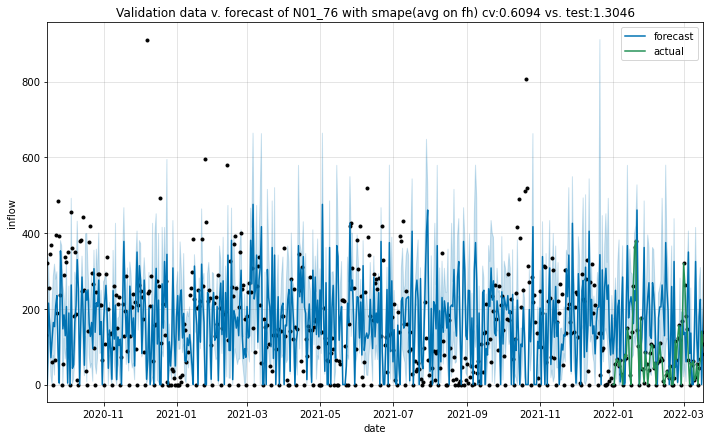

In [30]:
plot_forecast(forecast_pd, model_cv_smape, last_train_date, model, group_name )

In [ ]:
check_key1 = 'N01' # N01_62
check_key2 = '62'
group_name = '{}_{}'.format(check_key1, check_key2)
experiment_id = '1'

# extract the forecast for a specific ts_key as example
forecast = (df_input.filter((col("Key1") == check_key1) 
                             & (col("Key2") == check_key2))
                            .groupBy('Key1', 'Key2')
                            .applyInPandas(apply_models, schema = forecast_schema ))

# extract the forecast for a specific ts_key as example
forecast_pd = (
    forecast
    .select(['ds','y','yhat','yhat_lower','yhat_upper'])
    .filter((col('Key1')==check_key1) & (col('Key2')==check_key2))
    ).toPandas()

model, best_run_df, model_cv_smape = load_model(check_key1, check_key2, experiment_id, group_name)

In [ ]:
plot_forecast(forecast_pd, model_cv_smape, last_train_date, model, group_name )